In [294]:
%matplotlib inline  

import os
import re
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import json

plt.rcParams["figure.figsize"] = (20,6)
plt.rcParams['font.size'] = 22

In [695]:
num_users = 100
frac = 0.05
local_ep = 1
unbalanced = True

global_ep = 1000

shard_per_user = 2

#dataset = 'mnist'
dataset = 'cifar10'
# dataset = 'cifar100'

In [696]:
if dataset == 'mnist':
    model = 'mlp'
else:
    model = 'cnn'

iid = False
if unbalanced:
    #data_dict_fname = 'unbalanced_dict_users_2.pkl'
    data_dict_fname = 'clsimb_dict_users.pkl'
else:
    data_dict_fname = 'shared_dict_users.pkl'

    if shard_per_user == 10:
        iid = True

In [697]:
#save\mnist\mlp_iidTrue_num100_C0.1_le1\shard10\run1\fed
base_dir = './save/{}/{}_iid{}_num{}_C{}_le{}/shard{}/'.format(
    dataset, model, iid, num_users, frac, local_ep, shard_per_user)
runs = os.listdir(base_dir)
print(runs)
#runs = ['selection'] # diff data distribution
#runs = ['selection1', 'selection2', 'selection3', 'selection4', 'selection5']
#runs = ['selection1']
runs = ['cossim_cls_imb']
#runs = ['cossim_test']
print(runs)
print(os.listdir(os.path.join(base_dir, runs[0])))

['cossim2_c0.05', 'cossim1', 'cossim_test', 'cossim_square', '_distr_config', 'cossim_cls_imb', 'cossim2']
['cossim_cls_imb']
['algo5_deg3', 'utility', 'algo1_r1.0', 'algo5_deg9', 'fedavg_c0.05', 'algo5', 'algo5_deg7', 'algo2_loss-ratio', 'algo5_deg5']


In [698]:
shard_path = './save/{}/data_distr/num{}/shard{}/'.format(
        dataset, num_users, shard_per_user)
data_dict_path = os.path.join(shard_path, data_dict_fname)
with open(data_dict_path, 'rb') as handle:
    (dict_users_train, dict_users_test, _) = pickle.load(handle)
local_data_size = []
for idx in range(num_users):
    local_data_size.append(len(dict_users_train[idx]))
print('local dataset size: ', local_data_size)

local dataset size:  [250, 500, 250, 500, 250, 750, 250, 250, 250, 250, 500, 500, 500, 500, 750, 500, 750, 250, 500, 500, 500, 250, 500, 250, 750, 500, 750, 500, 750, 500, 250, 250, 750, 500, 500, 500, 250, 750, 500, 250, 750, 250, 750, 500, 500, 250, 500, 250, 750, 500, 250, 500, 750, 500, 1000, 500, 250, 750, 500, 500, 250, 500, 500, 500, 250, 500, 1000, 500, 500, 1000, 500, 500, 250, 500, 1000, 250, 750, 250, 250, 250, 250, 500, 250, 250, 500, 250, 250, 250, 250, 250, 250, 500, 250, 500, 500, 500, 250, 250, 250, 250]


### 10/100

===  cossim_cls_imb  ===
fedavg, best_acc 52.9 ===================

utility , best_acc 54.12 ===================

algo5_deg3 , best_acc 55.37 ===================

algo5_deg5 , best_acc 55.03 ===================

algo5_deg7 , best_acc 55.31 ===================

algo5_deg9 , best_acc 54.64 ===================

bacc summary: [52.9, 54.12, 55.37, 55.03, 55.31, 54.64]


'    \nplt.rcParams["figure.figsize"] = (20,6)\n#plt.rcParams[\'font.size\'] = 22\nplt.figure()\nplt.title(\'final acc\')\nplt.plot(range(len(acc_fed)), acc_fed, label=\'random\')    \nplt.plot(range(len(acc_utility)), acc_utility, label=algo + \' utility\')\nplt.xlabel(\'run\')\nplt.ylabel(\'acc\')\nplt.legend()\n'

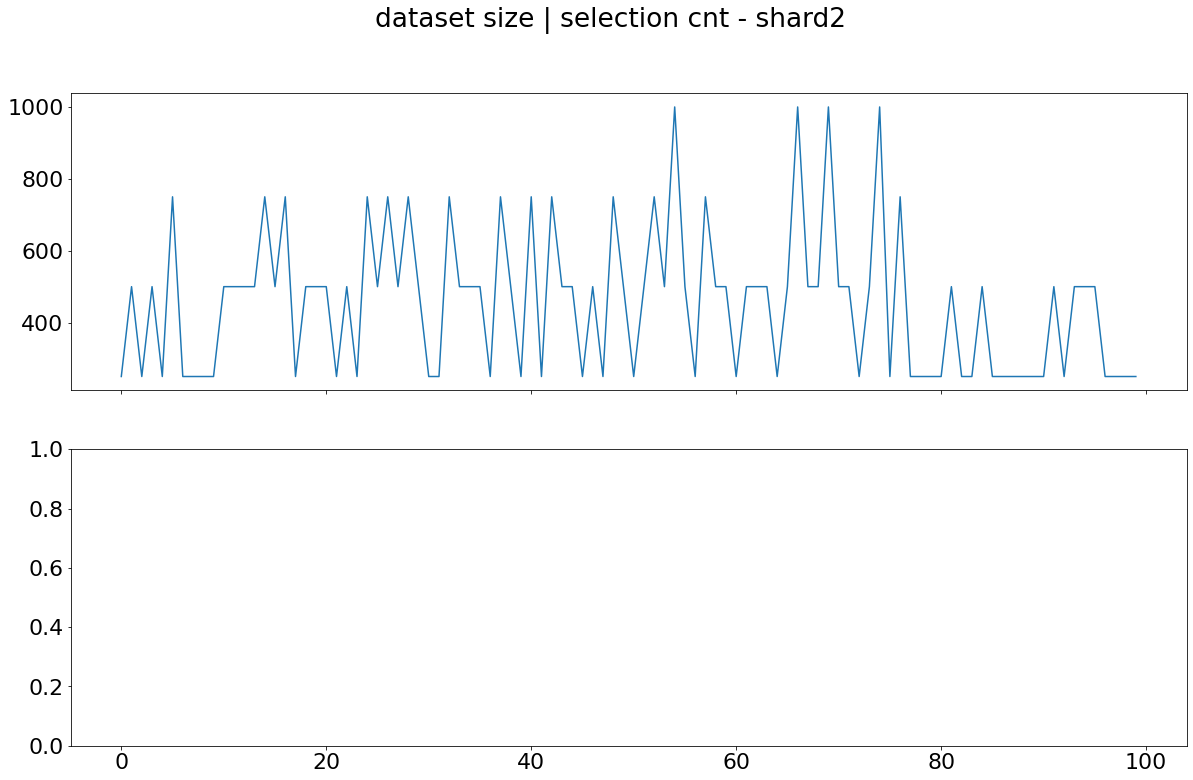

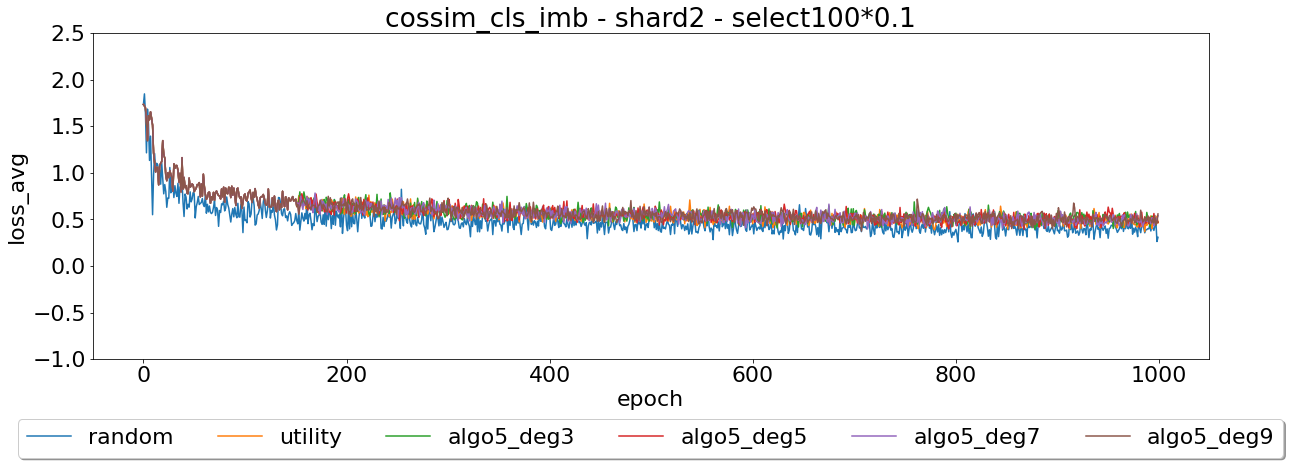

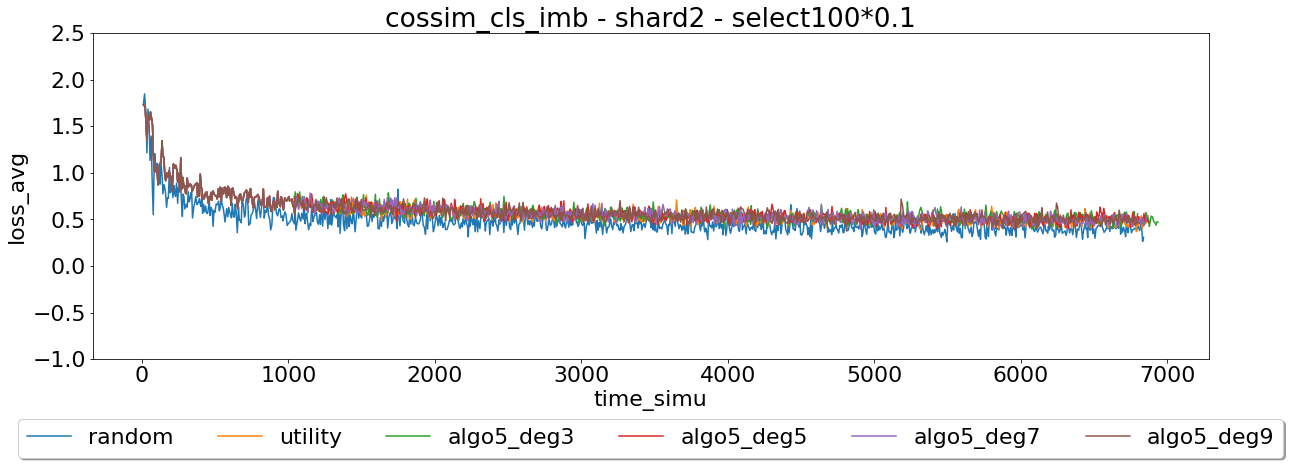

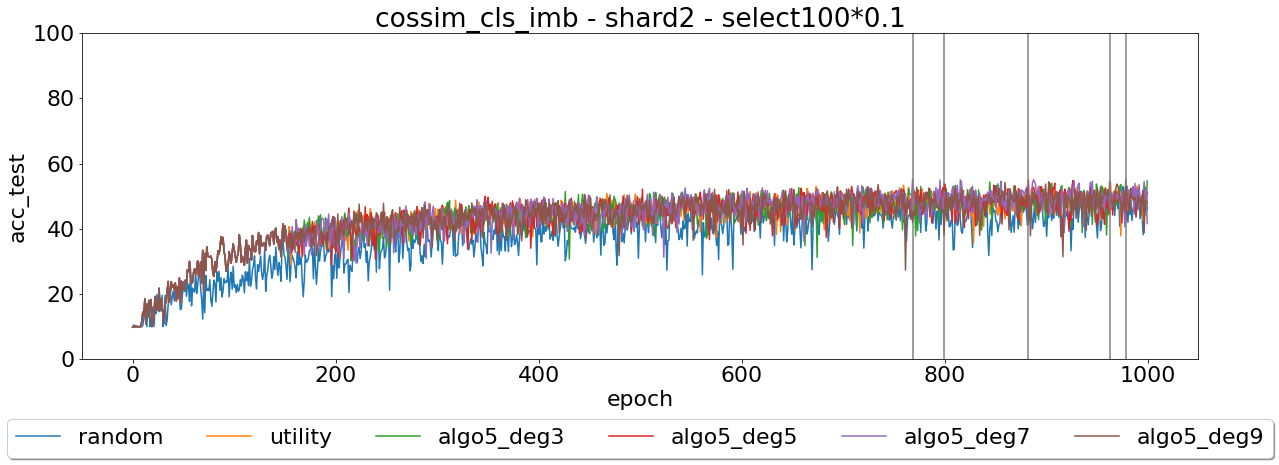

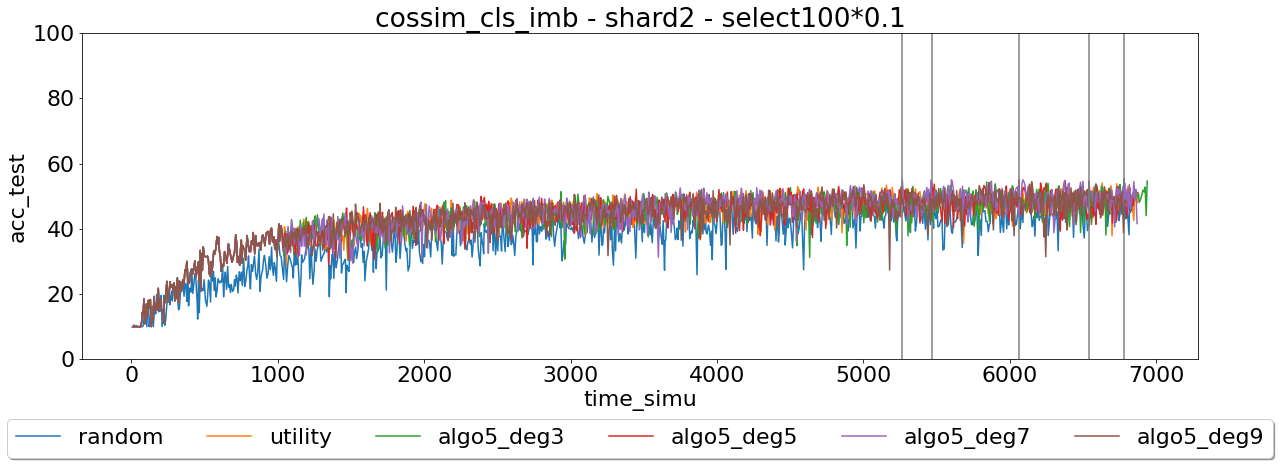

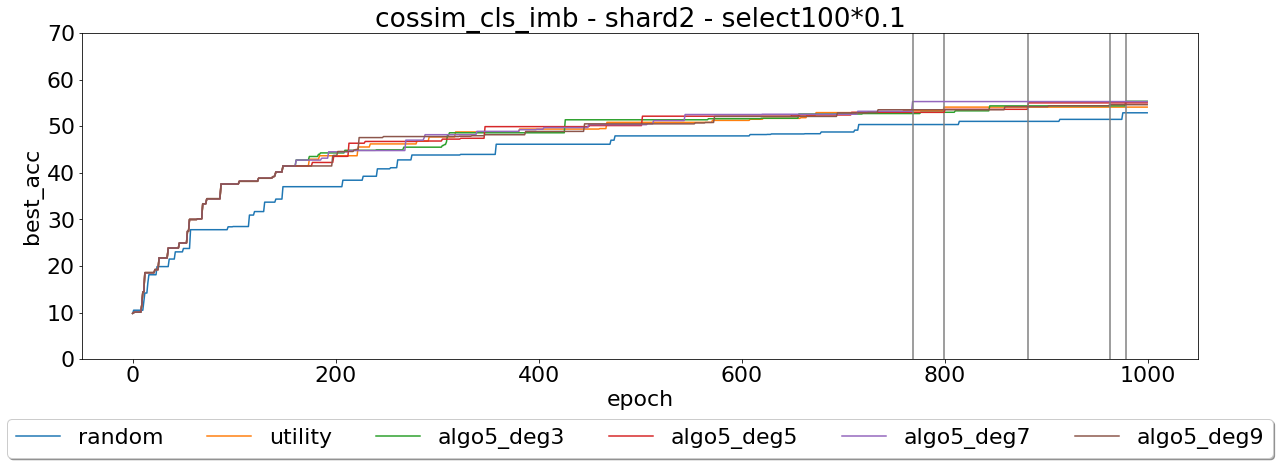

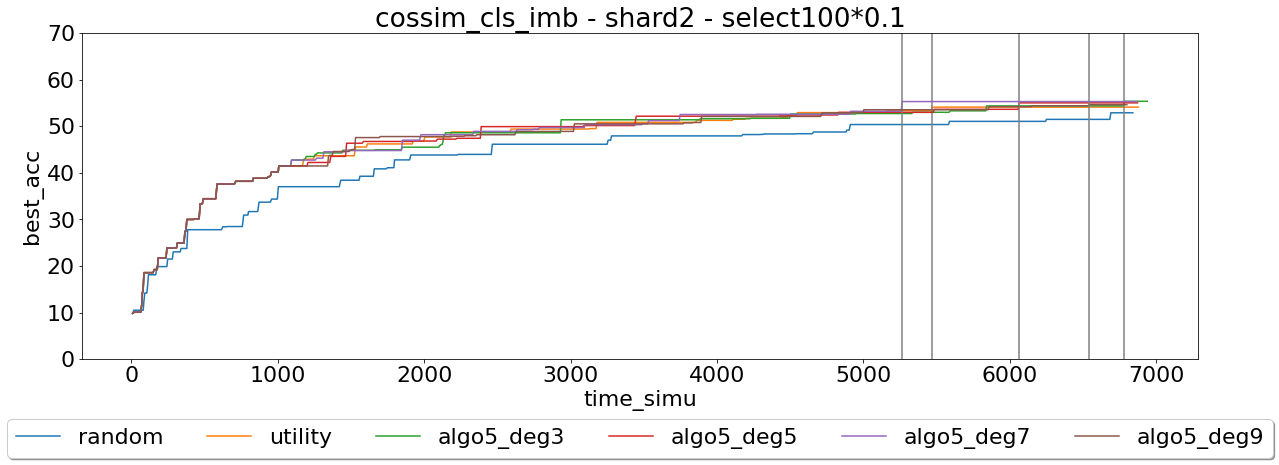

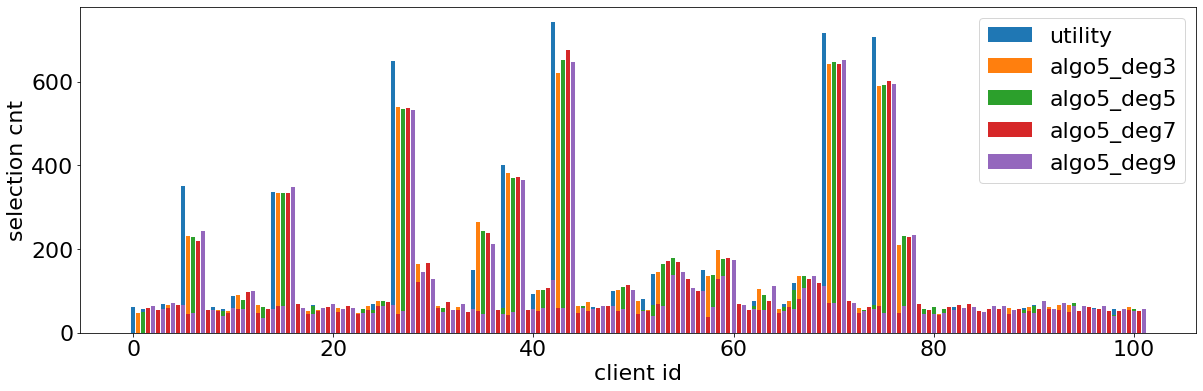

In [689]:
frac = 0.1
acc_fed = np.zeros(len(runs))
acc_utility = np.zeros(len(runs))
acc_local_localtest = np.zeros(len(runs))
acc_local_newtest_avg = np.zeros(len(runs))
acc_local_newtest_ens = np.zeros(len(runs))
lg_metrics = {}
bacc_algos = []

fig, axs = plt.subplots(len(runs)+1, sharex=True, figsize=(20, 12))
fig.suptitle('dataset size | selection cnt - shard' + str(shard_per_user))
axs[0].plot(range(len(local_data_size)), local_data_size,label='local data size')
acc_algo = []

for idx, run in enumerate(runs):
    print('=== ', run, ' ===')
    # FedAvg
    
    base_dir_fed = os.path.join(base_dir, "{}/fedavg_c{}".format(run, frac))
    if os.path.exists(base_dir_fed):
        results_path_fed = os.path.join(base_dir_fed, "results.csv")
        cossim_path_fed = os.path.join(base_dir_fed, "cossim_glob_uni.csv")
        cossim_glob_uni_fed = np.genfromtxt(cossim_path_fed, delimiter=',')
        
        df_fed = pd.read_csv(results_path_fed)
        df_fed['cossim_glob_uni'] = cossim_glob_uni_fed
        #print(df_fed.head(20))
        df_fed = df_fed[:global_ep]
        #print(df_fed.shape)
        acc_fed[idx] = df_fed.loc[df_fed.shape[0]-1]['best_acc']
        acc_algo.append(acc_fed[idx])
        print('fedavg, best_acc', acc_fed[idx], '===================')
        print('')
        bacc_algos.append(acc_fed[idx])
    else:
        print('No random selection training result.')

    # fedavg w/ utility selection
    #gamma_opt = [0.1, 0.2, 0.4, 0.8, 1.6]
    #gamma_opt = [1, 2, 4, 8]
    gamma_opt = [0.1, 0.2, 0.4, 0.8, 1, 1.6, 2, 4, 8]
    gamma_path = ['gamma_3090/{}/algo1'.format(r) for r in gamma_opt]
    #utility_algos = ['utility_cossim']
    #utility_algos = ['utility_cossim', 'algo1', 'algo2','algo2_2']
    #utility_algos = ['utility_cossim', 'var_utility', 'algo1_r1.6','algo2_r1.6']
    utility_algos = ['utility_c0.1']

    if shard_per_user == 10:
        utility_algos = ['utility_c0.1', '_algo1_r1.6', 'algo2_r-loss']
        #utility_algos = ['utility_c0.1', 'algo1_r1.6']
    elif shard_per_user == 2:
        utility_algos = ['utility_c0.1', '_algo1_r0.8', 'algo2_r-loss']
        #utility_algos = ['utility_c0.1', 'algo1_r0.8']
    #utility_algos.extend(gamma_path)
    
    #utility_algos = ['utility_c0.1', 'algo1_r0.1', 'algo1_r1.0', 'algo1_r2.0']
    utility_algos = ['utility', 
                     #'algo1_r1.0',#'algo2_sq', 
                     #'algo2_loss-ratio',
                     'algo5_deg3', 'algo5_deg5', 'algo5_deg7', 'algo5_deg9'
                    ]
    
    df_utility = {} # algo -> df of result
    slctcnt = {}
    
    for algo in utility_algos:
        base_dir_utility = os.path.join(base_dir, '{}/{}'.format(run, algo))
        if os.path.exists(base_dir_utility):
            results_path_utility = os.path.join(base_dir_utility, "results.csv")
            slctcnt_path = os.path.join(base_dir_utility, "selection_cnt.csv")
            #cossim_path_utility = os.path.join(base_dir_utility, "cossim_glob_uni.csv")
            utility_path = os.path.join(base_dir_utility, "utility.csv")
            df_utility[algo] = pd.read_csv(results_path_utility)
            slctcnt[algo] = np.genfromtxt(slctcnt_path, delimiter=',')
            #cossim_glob_uni_utility = np.genfromtxt(cossim_path_utility, delimiter=',')
            #df_utility[algo]['cossim_glob_uni'] = cossim_glob_uni_utility
            #utility = np.genfromtxt(utility_path, delimiter='\n')

            #print(df_utility[algo].head(25))
            df_utility[algo] = df_utility[algo][:global_ep]
            #print(df_utility[algo].shape)
            acc_utility[idx] = df_utility[algo].loc[df_utility[algo].shape[0]-1]['best_acc']
            acc_algo.append(acc_utility[idx])
            
            print(algo,', best_acc', acc_utility[idx], '===================')
            print('')
            bacc_algos.append(acc_utility[idx])
        else:
            print('No {} utility selection training result.'.format(algo))


    print('bacc summary:', bacc_algos)
    #['loss_avg', 'loss_test', 'acc_test', 'best_acc']
    plt.rcParams["figure.figsize"] = (20,6)
    metrics = [('loss_avg',[-1, 2.5]), 
               ('acc_test', [0, 100]), 
               ('best_acc', [0, 70])]
               #('cossim_glob_uni', [0, 1])]
    
    for col, yl in metrics:
        for x in ['epoch', 'time_simu']:
            plt.figure()
            if os.path.exists(base_dir_fed):
                #plt.plot(df_fed[x], df_fed[col], label='random', marker='^')
                plt.plot(df_fed[x], df_fed[col], label='random')
                pass
            for algo in utility_algos:
                base_dir_utility = os.path.join(base_dir, '{}/{}'.format(run, algo))
                
                if os.path.exists(base_dir_utility):
                    #plt.plot(df_statsel[x], df_statsel[col], label='utility', marker='.')
                    plt.plot(df_utility[algo][x], df_utility[algo][col], label=algo)
                    if col == 'acc_test' or col == 'best_acc':
                        bacc = df_utility[algo]['best_acc'].iloc[-1]
                        bepc = df_utility[algo]['best_acc'].idxmax()
                        px = df_utility[algo][x][bepc]
                        max_px = df_utility[algo][x].iloc[-1]
                        #plt.plot([px], [bacc], 'o')
                        plt.axvline(x=px, color='grey')
                    '''
                    if col == 'best_acc' or 'loss_avg':
                        diff_bacc = df_utility[algo][col].diff()
                        ma_diff_bacc = -diff_bacc.rolling(20).sum()
                        
                        ma_bacc = df_utility[algo][col].rolling(10).mean()
                        #diff_ma_bacc = ma_bacc.diff()
                        #print(ma_diff_bacc[20:100])
                        plt.plot(df_utility[algo][x], diff_bacc, label=algo+' diff')
                        plt.plot(df_utility[algo][x], ma_diff_bacc, label=algo+' MA of diff')
                        plt.plot(df_utility[algo][x], ma_bacc, label=algo+' MA')
                        #plt.plot(df_utility[algo][x], diff_ma_bacc, label=algo+' diff of MA')
                        print('turning point of {}: {}'.format(algo, df_utility[algo][x][ma_diff_bacc.idxmin()]))
                    '''
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
                       fancybox=True, shadow=True, ncol=1+len(utility_algos))
            plt.ylabel(col)
            plt.xlabel(x)
            plt.ylim(yl)
            plt.title('{} - shard{} - select{}*{}'.format(run, shard_per_user, num_users, frac))
            #plt.title(run + ' - ' + str(shard_per_user) + ' class per client')
    
    
    plt.figure()
    for i, algo in enumerate(utility_algos):
        plt.bar(np.arange(len(slctcnt[algo]))+i*0.5, slctcnt[algo],
                width=0.4, label=algo)
    plt.ylabel('selection cnt')
    plt.xlabel('client id')
    plt.legend()
    
    #axs[idx+1].bar(range(len(slctcnt['utility_cossim'])), slctcnt['utility_cossim'])
    '''
    with open(utility_path) as fp_utility:
        plot_selection(fp_utility)
    '''


# final acc plot for multiple runs
'''    
plt.rcParams["figure.figsize"] = (20,6)
#plt.rcParams['font.size'] = 22
plt.figure()
plt.title('final acc')
plt.plot(range(len(acc_fed)), acc_fed, label='random')    
plt.plot(range(len(acc_utility)), acc_utility, label=algo + ' utility')
plt.xlabel('run')
plt.ylabel('acc')
plt.legend()
'''

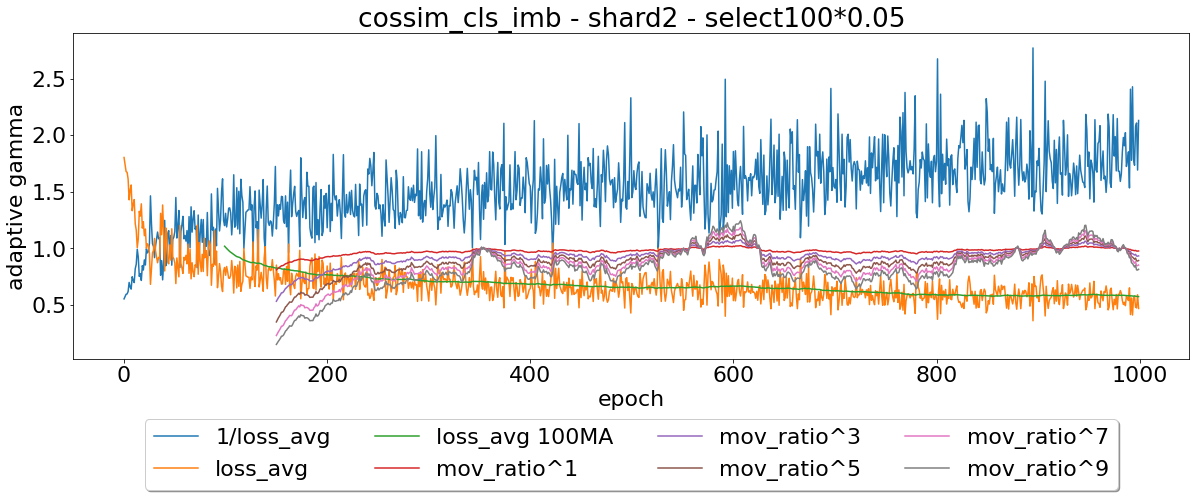

In [700]:
loss = df_utility['algo5_deg5']['loss_avg']
plt.figure()
plt.title('{} - shard{} - select{}*{}'.format(run, shard_per_user, num_users, frac))
plt.plot(range(1000), 1/loss, label='1/loss_avg')
plt.plot(range(1000), loss, label='loss_avg')
MA = loss.rolling(100).mean()
#VAR = loss.rolling(10).var()
#print(loss.rolling(100).mean().iloc[98:110])
plt.plot(range(1000), MA, label='loss_avg 100MA')
#plt.plot(range(1000), VAR, label='1/loss_avg VAR')
#print((MA.pct_change(periods=50)+1).iloc[99:150])
#plt.plot(range(1000), (MA.pct_change(periods=50)+1)**3, label='1/loss_avg change')

mov_sum = np.zeros(1000-100)
# mov_sum[i] = sum(loss_avg[i:i+args.wndw_size])
mov_ratio = np.zeros(1000-100-50)
for iter in range(1000):
    if iter >= 100: # start calculate mov_sum
            mov_sum[iter-100] = sum(loss[iter-100:iter])

    if iter >= 100+50: # start calculate mov_ratio
        midx = iter-100-50
        mov_ratio[midx] = mov_sum[midx+50]/mov_sum[midx]

for deg in [1,3,5,7,9]:
    plt.plot(range(150, 1000), mov_ratio**deg, label='mov_ratio^{}'.format(deg))
#plt.plot(range(1000), (1/loss)-0.3*loss, label='(1/loss)-0.3*loss')
#plt.plot(range(1000), (1/loss)**2, label='(1/loss_avg)^2')
plt.ylabel('adaptive gamma')
plt.xlabel('epoch')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=4)

### 5/100

===  cossim_cls_imb  ===
fedavg, best_acc 46.08 ===================

utility , best_acc 50.16 ===================

algo5_deg3 , best_acc 50.03 ===================

algo5_deg5 , best_acc 50.78 ===================

algo5_deg7 , best_acc 49.77 ===================

algo5_deg9 , best_acc 50.6 ===================

bacc summary: [46.08, 50.16, 50.03, 50.78, 49.77, 50.6]


'    \nplt.rcParams["figure.figsize"] = (20,6)\n#plt.rcParams[\'font.size\'] = 22\nplt.figure()\nplt.title(\'final acc\')\nplt.plot(range(len(acc_fed)), acc_fed, label=\'random\')    \nplt.plot(range(len(acc_utility)), acc_utility, label=algo + \' utility\')\nplt.xlabel(\'run\')\nplt.ylabel(\'acc\')\nplt.legend()\n'

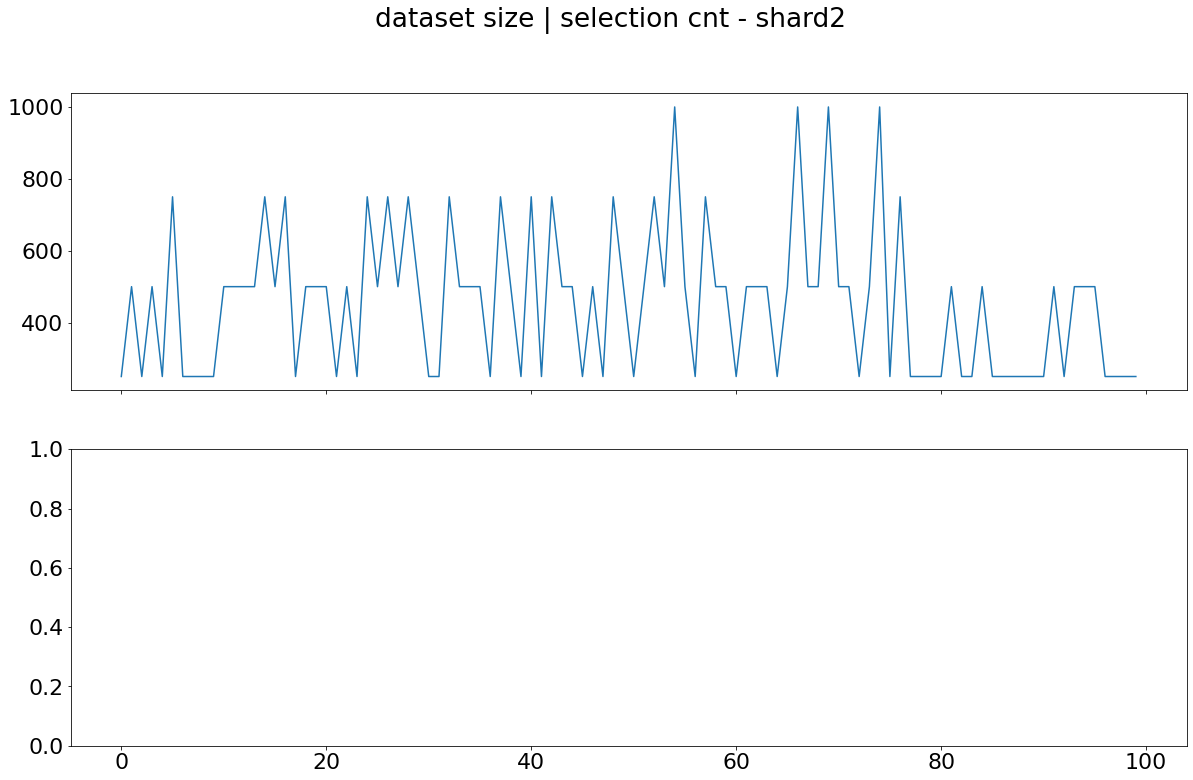

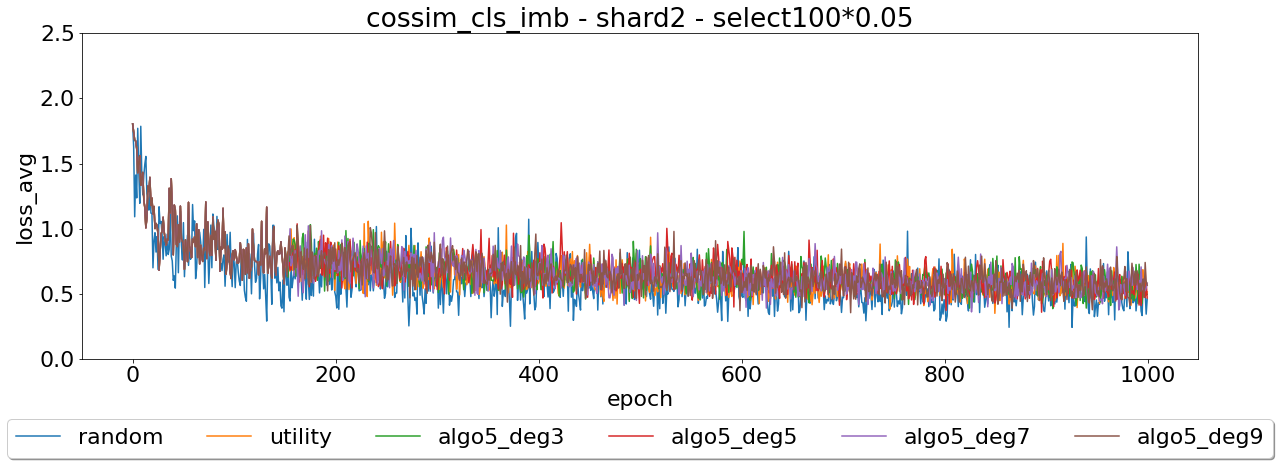

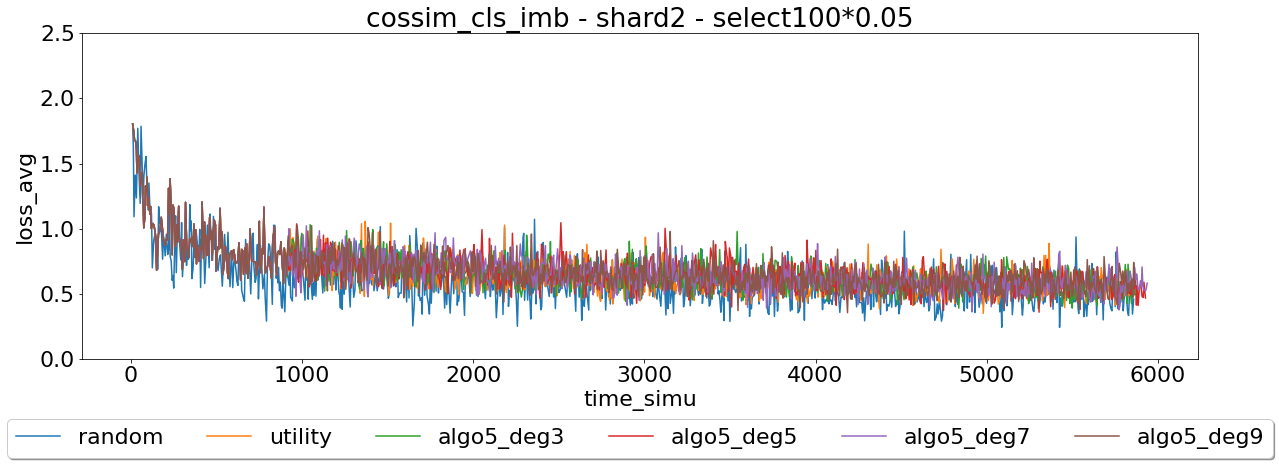

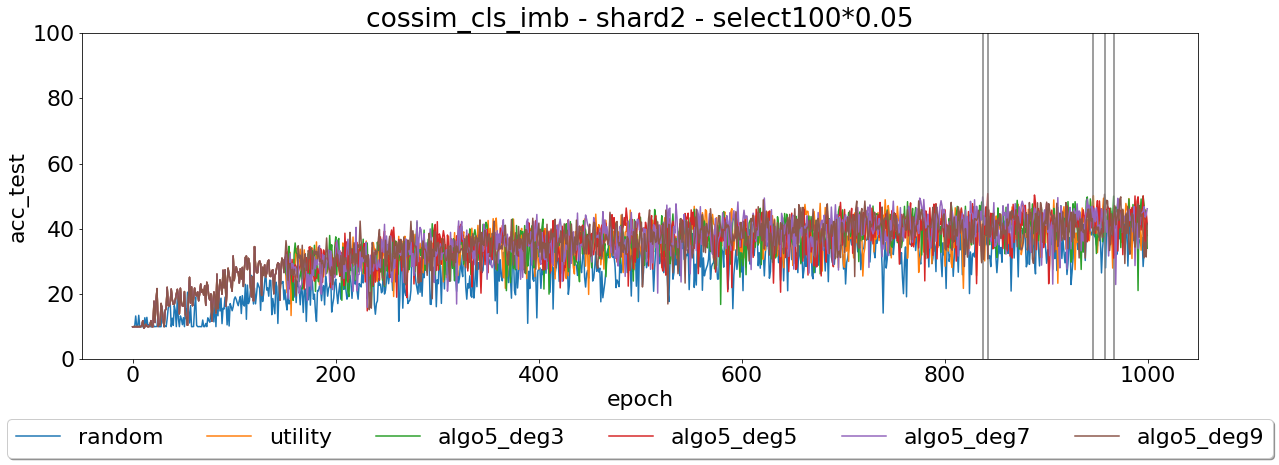

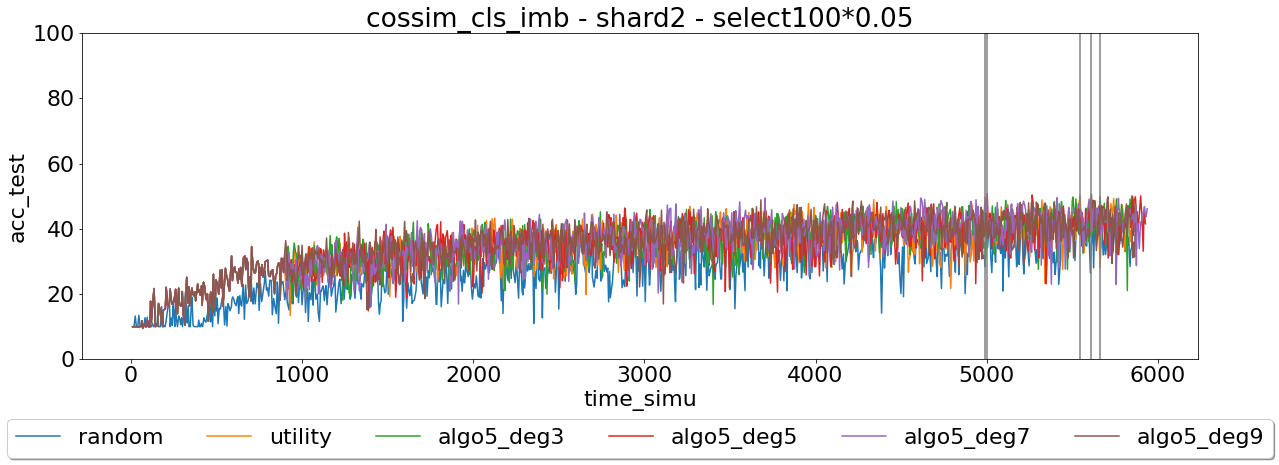

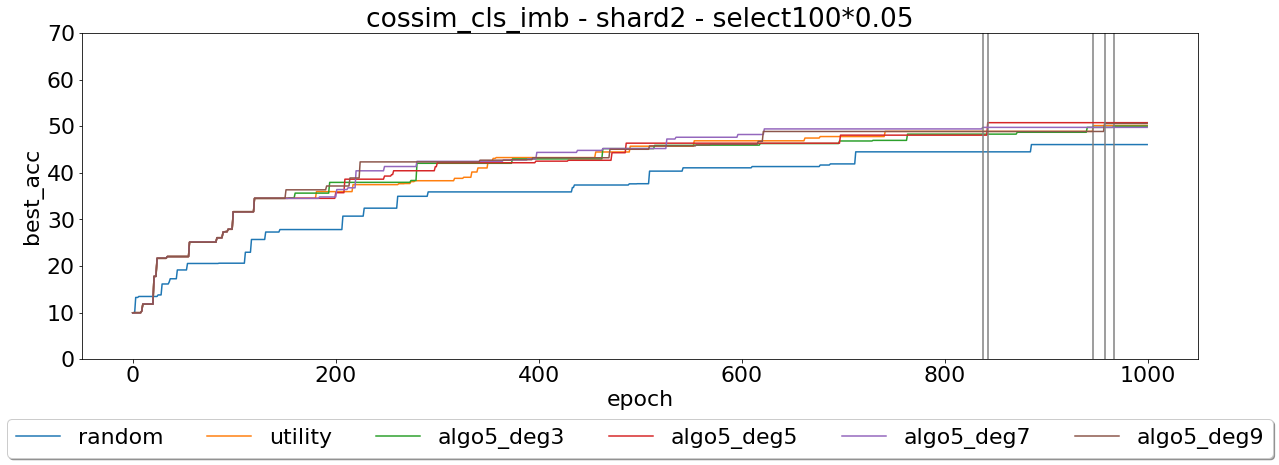

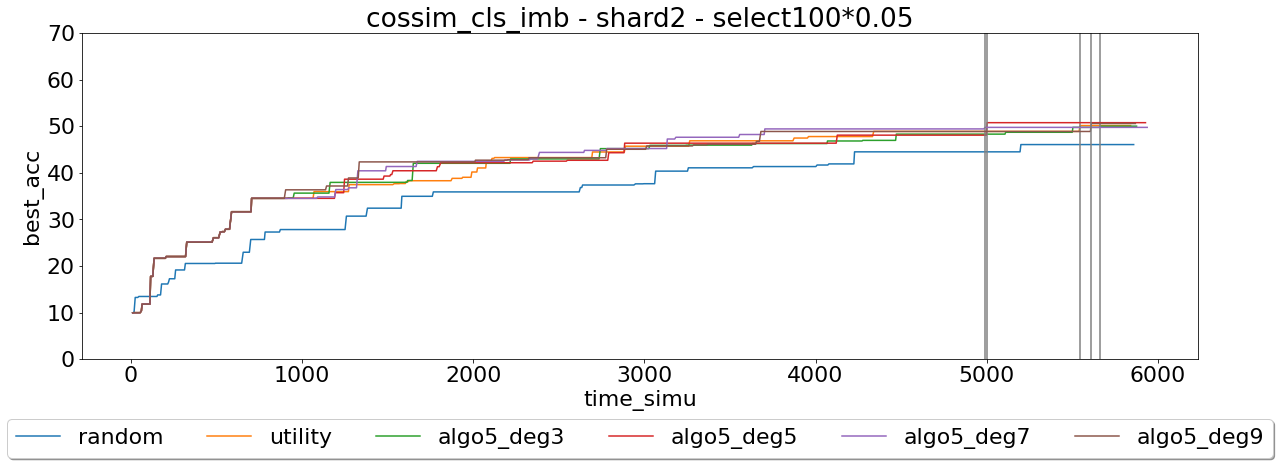

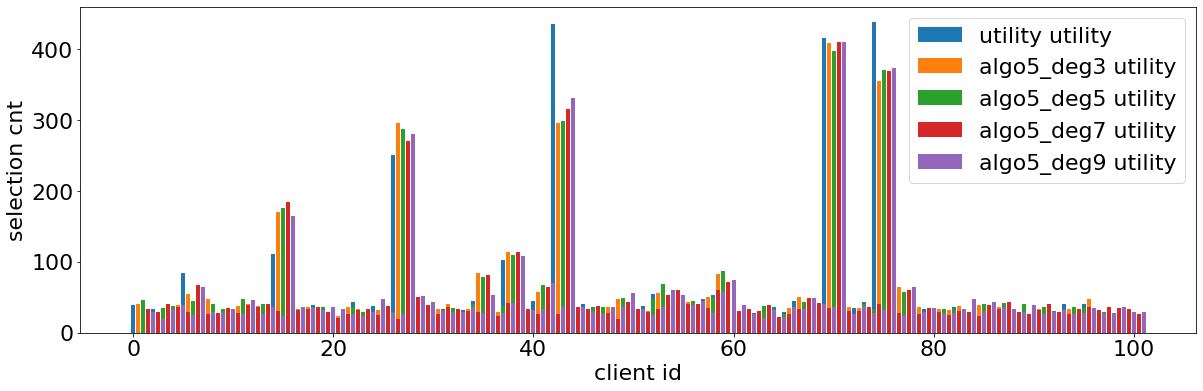

In [699]:
frac = 0.05

acc_fed = np.zeros(len(runs))
acc_utility = np.zeros(len(runs))
acc_local_localtest = np.zeros(len(runs))
acc_local_newtest_avg = np.zeros(len(runs))
acc_local_newtest_ens = np.zeros(len(runs))
lg_metrics = {}
bacc_algos = []


fig, axs = plt.subplots(len(runs)+1, sharex=True, figsize=(20, 12))
fig.suptitle('dataset size | selection cnt - shard' + str(shard_per_user))
axs[0].plot(range(len(local_data_size)), local_data_size,label='local data size')

for idx, run in enumerate(runs):
    print('=== ', run, ' ===')
    # FedAvg
    
    base_dir_fed = os.path.join(base_dir, "{}/fedavg_c{}".format(run, frac))
    if os.path.exists(base_dir_fed):
        results_path_fed = os.path.join(base_dir_fed, "results.csv")
        cossim_path_fed = os.path.join(base_dir_fed, "cossim_glob_uni.csv")
        cossim_glob_uni_fed = np.genfromtxt(cossim_path_fed, delimiter=',')
        
        df_fed = pd.read_csv(results_path_fed)
        df_fed['cossim_glob_uni'] = cossim_glob_uni_fed
        #print(df_fed.head(20))
        df_fed = df_fed[:global_ep]
        #print(df_fed.shape)
        acc_fed[idx] = df_fed.loc[df_fed.shape[0]-1]['best_acc']
        print('fedavg, best_acc', acc_fed[idx], '===================')
        print('')
        bacc_algos.append(acc_fed[idx])
    else:
        print('No random selection training result.')

    # fedavg w/ utility selection
    #gamma_opt = [0.1, 0.2, 0.4, 0.8, 1.6]
    gamma_opt = [1.6]
    gamma_path = ['gamma_3090/{}/algo1'.format(r) for r in gamma_opt]
    #utility_algos = ['utility_cossim', 'algo1', 'algo2','algo2_2']
    #utility_algos = ['utility_cossim', 'var_utility', 'algo1_r1.6','algo2_r1.6']
    
    if shard_per_user == 10:
        #utility_algos = ['utility_cossim', 'algo1_r1.6', 'algo2_r1.6']
        utility_algos = ['utility_c0.05', '_algo1_r1.6_c0.05', 'algo2_r-loss_c0.05']
    elif shard_per_user == 2:
        #utility_algos = ['utility_cossim', 'algo1_r0.8', 'algo2_r0.8']
        utility_algos = ['utility_c0.05', '_algo1_r0.8_c0.05', 'algo2_r-loss_c0.05']
    #utility_algos.extend(gamma_path)
    #utility_algos = ['utility_c0.05', 'algo1_r0.1_c0.05', 'algo1_r1.0_c0.05', 'algo1_r2.0_c0.05', 'algo2_r-loss_c0.05']
    utility_algos = ['utility_c0.05',
                     'algo1_r0.1_c0.05', 'algo1_r1.0_c0.05','algo1_r2.0_c0.05'
                     #'algo2_r-loss_c0.05','algo2_r-loss2_c0.05'
                    ]
    #utility_algos = ['utility', 'algo1_r1.0', 'algo2_loss-ratio', 'algo5']
    utility_algos = ['utility', 
                     #'algo1_r1.0',#'algo2_sq', 
                     #'algo2_loss-ratio',
                     'algo5_deg3', 'algo5_deg5', 'algo5_deg7', 'algo5_deg9'
                    ]
    
    df_utility = {} # algo -> df of result
    slctcnt = {}
    
    for algo in utility_algos:
        base_dir_utility = os.path.join(base_dir, '{}/{}'.format(run, algo))
        if os.path.exists(base_dir_utility):
            results_path_utility = os.path.join(base_dir_utility, "results.csv")
            slctcnt_path = os.path.join(base_dir_utility, "selection_cnt.csv")
            #cossim_path_utility = os.path.join(base_dir_utility, "cossim_glob_uni.csv")
            utility_path = os.path.join(base_dir_utility, "utility.csv")
            df_utility[algo] = pd.read_csv(results_path_utility)
            slctcnt[algo] = np.genfromtxt(slctcnt_path, delimiter=',')
            #cossim_glob_uni_utility = np.genfromtxt(cossim_path_utility, delimiter=',')
            #df_utility[algo]['cossim_glob_uni'] = cossim_glob_uni_utility
            #utility = np.genfromtxt(utility_path, delimiter='\n')

            #print(df_utility[algo].head(25))
            df_utility[algo] = df_utility[algo][:global_ep]
            #print(df_utility[algo].shape)
            acc_utility[idx] = df_utility[algo].loc[df_utility[algo].shape[0]-1]['best_acc']
            print(algo,', best_acc', acc_utility[idx], '===================')
            print('')
            bacc_algos.append(acc_utility[idx])
            
        else:
            print('No {} utility selection training result.'.format(algo))


    print('bacc summary:', bacc_algos)
    #['loss_avg', 'loss_test', 'acc_test', 'best_acc']
    plt.rcParams["figure.figsize"] = (20,6)
    metrics = [('loss_avg', [0, 2.5]), 
               ('acc_test', [0, 100]), 
               ('best_acc', [0, 70])]
               #('cossim_glob_uni', [0, 1])]
    
    for col, yl in metrics:
        for x in ['epoch', 'time_simu']:
            plt.figure()
            ann_idx = 5
            
            if os.path.exists(base_dir_fed):
                #plt.plot(df_fed[x], df_fed[col], label='random', marker='^')
                plt.plot(df_fed[x], df_fed[col], label='random')
                pass
            for algo in utility_algos:
                base_dir_utility = os.path.join(base_dir, '{}/{}'.format(run, algo))
                
                if os.path.exists(base_dir_utility):
                    #plt.plot(df_statsel[x], df_statsel[col], label='utility', marker='.')
                    plt.plot(df_utility[algo][x], df_utility[algo][col], label=algo)
                    
                    if col == 'acc_test' or col == 'best_acc':
                        bacc = df_utility[algo]['best_acc'].iloc[-1]
                        bepc = df_utility[algo]['best_acc'].idxmax()
                        px = df_utility[algo][x][bepc]
                        max_px = df_utility[algo][x].iloc[-1]
                        #plt.plot([px], [bacc], 'o')
                        plt.axvline(x=px, color='grey')
                        '''
                        plt.annotate('{}'.format(bacc), xy=(px, bacc),
                                     xytext=(px**2/max_px/2, 100*(1-px/max_px)*1.5),
                                     arrowprops=dict(color=(0,0,0,0.5), shrink=0.05, width=0.3))
                        '''
                        ann_idx -= 1
                    '''
                    # test
                    if col == 'best_acc' or col == 'loss_avg':
                        diff_bacc = df_utility[algo][col].diff()
                        ma_diff_bacc = diff_bacc.rolling(20).sum()
                        #print(ma_diff_bacc[:30])
                        plt.plot(df_utility[algo][x], diff_bacc, label=algo+' diff')
                        plt.plot(df_utility[algo][x], ma_diff_bacc, label=algo+' MA')
                        print('turning point of {}: {}'.format(algo, df_utility[algo][x][ma_diff_bacc.idxmin()]))
                    '''
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
                       fancybox=True, shadow=True, ncol=1+len(utility_algos))
            plt.ylabel(col)
            plt.xlabel(x)
            plt.ylim(yl)
            plt.title('{} - shard{} - select{}*{}'.format(run, shard_per_user, num_users, frac))
            #plt.title(run + ' - ' + str(shard_per_user) + ' class per client')
    
    
    plt.figure()
    for i, algo in enumerate(utility_algos):
        plt.bar(np.arange(len(slctcnt[algo]))+i*0.5, slctcnt[algo],
                width=0.4, label=algo + ' utility')
    plt.ylabel('selection cnt')
    plt.xlabel('client id')
    plt.legend()
    
    #axs[idx+1].bar(range(len(slctcnt['utility_cossim'])), slctcnt['utility_cossim'])
    '''
    with open(utility_path) as fp_utility:
        plot_selection(fp_utility)
    '''


# final acc plot for multiple runs
'''    
plt.rcParams["figure.figsize"] = (20,6)
#plt.rcParams['font.size'] = 22
plt.figure()
plt.title('final acc')
plt.plot(range(len(acc_fed)), acc_fed, label='random')    
plt.plot(range(len(acc_utility)), acc_utility, label=algo + ' utility')
plt.xlabel('run')
plt.ylabel('acc')
plt.legend()
'''

### impact of gamma (only valid for c0.1)

[]


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

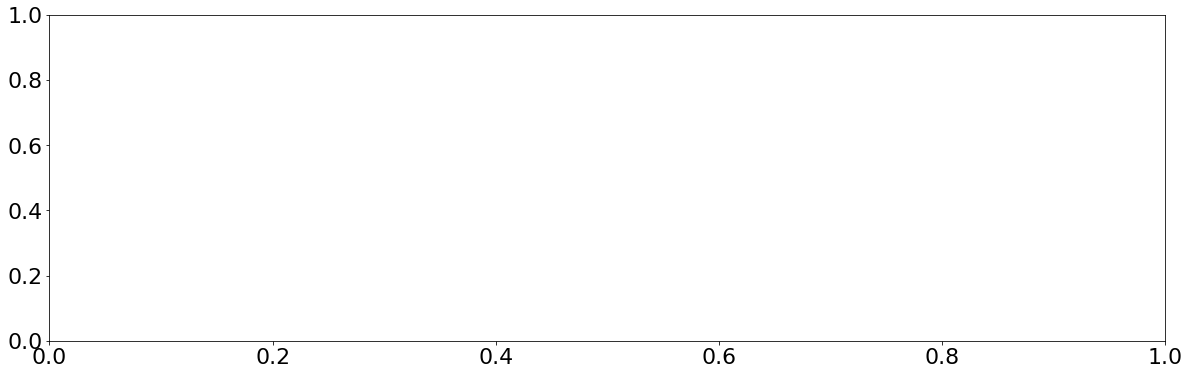

In [292]:
eq_gamma_opt = [0,]
eq_gamma_opt.extend(gamma_opt)
print(acc_algo)
plt.figure()
plt.plot(range(len(eq_gamma_opt)), acc_algo, marker='o')
plt.xticks(np.arange(len(eq_gamma_opt)), eq_gamma_opt)
plt.xlabel('gamma option')
plt.ylabel('final best acc')
plt.title('{} - shard{} - select{}*{}'.format(run, shard_per_user, num_users, frac))


KeyError: 'algo2_r1.6'

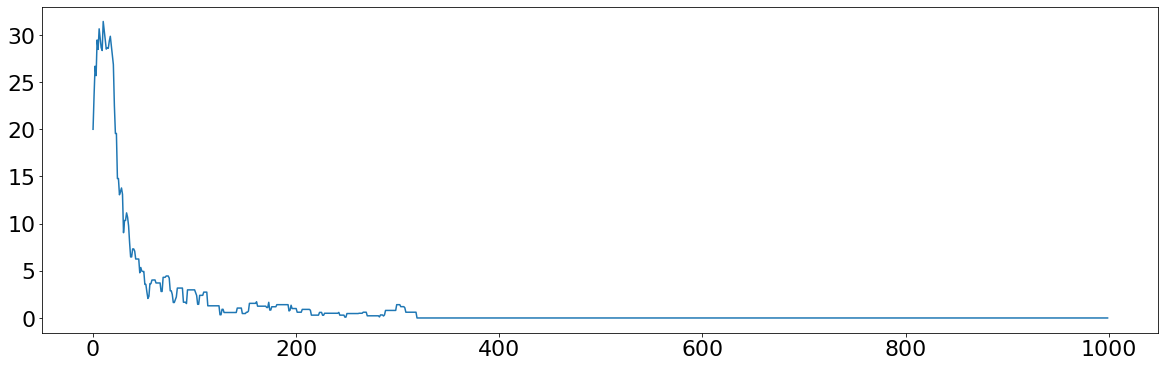

In [201]:
plt.figure()
algo_list = ['algo1_r1.6', 'algo2_r1.6']
for algo in algo_list:
    plt.plot(df_utility[algo]['epoch'], df_utility[algo]['mov_sum'], label=algo+ ' utility')


[ 1.  2.  3.  5.  6.  5.  2.  4.  5.  8.  3.  5.  4.  4.  2.  2.  3.  4.
  5.  4.  2.  5.  2.  3.  6.  3.  6.  1.  7.  2.  3.  3.  3.  2.  4.  2.
  3.  3.  1.  1.  2.  4.  1.  1.  5.  1.  3.  2.  3.  5. 10.  4.  4.  3.
  2.  3.  4.  5.  3.  1.  1.  1.  4.  4.  4.  1.  5.  1.  3.  6.  4.  3.
  2.  1.  2.  3.  2.  2.  5.  2.  2.  5.  5.  5.  5.  5.  6.  2.  3.  4.
  6.  2.  2.  2.  6.  2.  6.  5.  7.  4.]


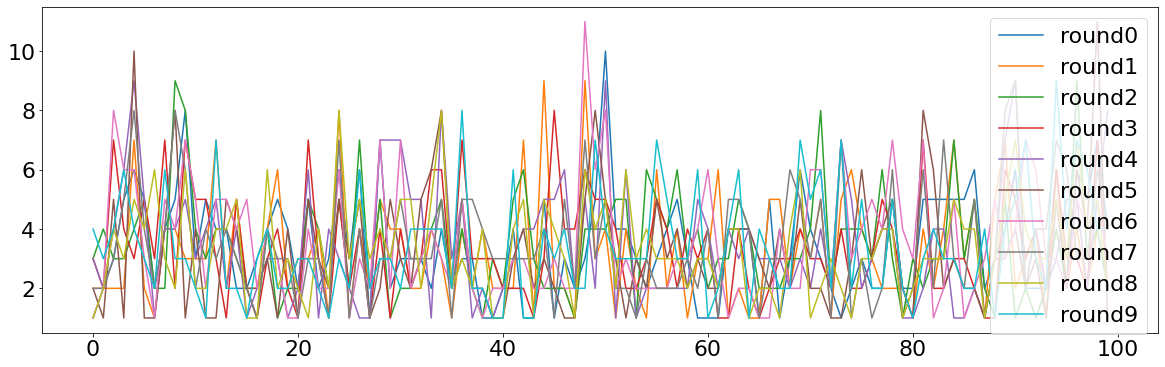

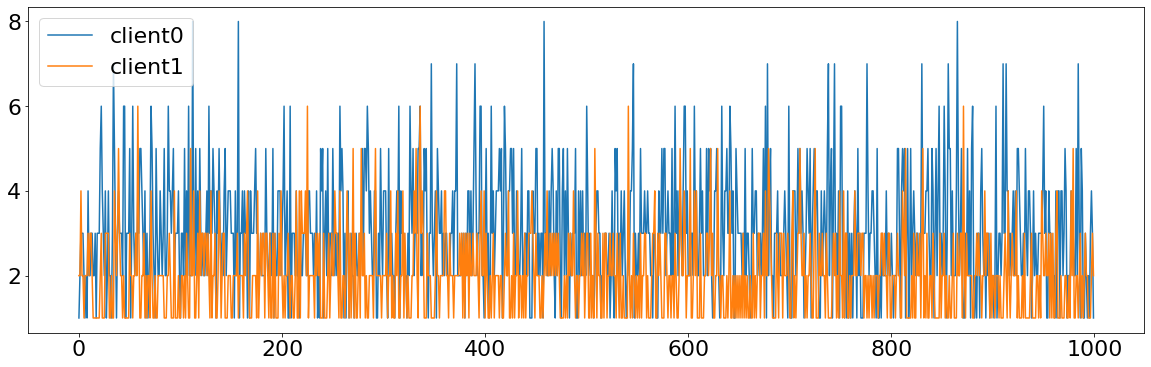

In [34]:
# plot t_i
ti_path = './save/user_config/var_time/{}_{}.csv'.format(dataset, num_users)
ti_all = np.genfromtxt(ti_path, delimiter=',')

plt.figure()
for ep in range(10):
    plt.plot(range(num_users), ti_all[:, ep], label='round'+str(ep))
    plt.legend()

print(ti_all[:,0])
plt.figure()
for user in range(2):
    plt.plot(range(global_ep), ti_all[user], label='client'+str(user))
    plt.legend()
